In [1]:
import numpy as np
import numba
from numba import jit

In [2]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
N_CARDS = 3
RESOLUTION = 10
N_ACTIONS = 2
N_GAMES = 10000
BET_SIZE = 1
POPULATION_SIZE = 50
TOURNAMENT_PROB = 0.7
CROSSOVER_PROB = 0.5
MUTATION_PROB = 0.1/RESOLUTION
CARDS = np.arange(N_CARDS)
INDIVIDUALS = np.arange(POPULATION_SIZE)
MAX_SCORE = N_GAMES*POPULATION_SIZE*POPULATION_SIZE*2
DECODING_VECTOR =np.power(2*np.ones(RESOLUTION),-np.arange(1,RESOLUTION+1))

<img src="kuhns_poker_no_fold.png">

In [ ]:
@jit(nopython=True)
def play_4_simple(p1, p2):

    p1_card, p2_card =  np.random.permutation(CARDS)[:2]
    
    
    
    p1_bets =  np.random.rand() < p1[p1_card,0,:]@DECODING_VECTOR
   
    
    if(p1_bets):
        p2_bets = np.random.rand() < p2[p2_card,0,:]@DECODING_VECTOR

        if(p2_bets):
            if(p1_card > p2_card):
                return (2*BET_SIZE,-2*BET_SIZE)
            else: 
                return (-2*BET_SIZE,2*BET_SIZE)
        elif(not p2_bets):
            return (BET_SIZE,-BET_SIZE)
        
    elif(not p1_bets):
        p2_bets = np.random.rand() < p2[p2_card,1,:]@DECODING_VECTOR
        
        if(p2_bets):
            p1_bets_again =  np.random.rand() < p1[p1_card,1,:]@DECODING_VECTOR
            
            if(p1_bets_again):
                if(p1_card > p2_card):
                    return (2*BET_SIZE,-2*BET_SIZE)
                else: 
                    return (-2*BET_SIZE,2*BET_SIZE)
            elif(not p1_bets_again):
                return (-BET_SIZE,BET_SIZE)
        
        elif(not p2_bets):
            if(p1_card > p2_card):
                return (BET_SIZE,-BET_SIZE)
            else: 
                return (-BET_SIZE,BET_SIZE)



In [32]:
@jit(nopython=True)
def play(p1, p2):

    p1_card, p2_card =  np.random.permutation(CARDS)[:2]
    
    p1_bets =  np.random.rand() < p1[p1_card,0,:]@DECODING_VECTOR
   
    
    if(p1_bets):
        p2_bets = np.random.rand() < p2[p2_card,0,:]@DECODING_VECTOR

        if(p2_bets):
            if(p1_card > p2_card):
                return (2*BET_SIZE,-2*BET_SIZE)
            else: 
                return (-2*BET_SIZE,2*BET_SIZE)
        elif(not p2_bets):
            return (BET_SIZE,-BET_SIZE)
        
    elif(not p1_bets):
        p2_bets = np.random.rand() < p2[p2_card,1,:]@DECODING_VECTOR
        
        if(p2_bets):
            p1_bets_again =  np.random.rand() < p1[p1_card,1,:]@DECODING_VECTOR
            
            if(p1_bets_again):
                if(p1_card > p2_card):
                    return (2*BET_SIZE,-2*BET_SIZE)
                else: 
                    return (-2*BET_SIZE,2*BET_SIZE)
            elif(not p1_bets_again):
                return (-BET_SIZE,BET_SIZE)
        
        elif(not p2_bets):
            if(p1_card > p2_card):
                return (BET_SIZE,-BET_SIZE)
            else: 
                return (-BET_SIZE,BET_SIZE)


In [33]:
@jit(nopython=True)
def evaluate(population_1, population_2):
 
    fitness_1 = np.zeros(POPULATION_SIZE)
    fitness_2 = np.zeros(POPULATION_SIZE) 

    for player in INDIVIDUALS:
        for opponent in INDIVIDUALS:
            for game in range(N_GAMES):
                player_score, opponent_score = play(population_1[player], population_2[opponent])
                fitness_1[player] += player_score
                fitness_2[opponent] += opponent_score
    
    


    return (fitness_1/(N_GAMES*POPULATION_SIZE), fitness_2/(N_GAMES*POPULATION_SIZE))

In [34]:
@jit(nopython=True)
def tournament_selection(population, fitness):
    
    p = np.random.permutation(POPULATION_SIZE)
    
    i1 = p[0]
    i2 = p[1]
    
    if(fitness[i1] > fitness[i2]):
        i_max = i1
        i_min = i2
    else:
        i_max = i2
        i_min = i1
    
    if(np.random.rand() < TOURNAMENT_PROB):
        return i_max
    else:
        return i_min
            
def wheel_selection(population, fitness):
    temp = fitness + np.min(fitness)
    distribution = temp/np.sum(temp)
    return np.random.choice(np.arange(POPULATION_SIZE), p= distribution)
    

In [35]:
@jit(nopython=True)
def crossover(individual_1, individual_2):
    
    if(np.random.rand() < CROSSOVER_PROB):
        child_1 = np.zeros_like(individual_1)
        child_2 = np.zeros_like(individual_1)

        for i in range(N_CARDS):
            for j in range(N_ACTIONS):
                cp = np.random.randint(RESOLUTION)
                child_1[i,j,:] = np.concatenate((individual_1[i,j,:cp],individual_2[i,j,cp:]))
                child_2[i,j,:] = np.concatenate((individual_2[i,j,:cp],individual_1[i,j,cp:]))

        return(child_1, child_2)
    else:
        return(individual_1, individual_2)

In [36]:
#@jit(nopython=True)
def mutate(individual):
    
    mutated_genes = np.random.rand(N_CARDS, N_ACTIONS, RESOLUTION) < MUTATION_PROB
    individual[mutated_genes] = 1-individual[mutated_genes]
    

    return individual

In [37]:
def print_player(player):

    print("Card \t      a0 prob \t      a2 prob")
    for card in range(N_CARDS):
         print("  {:d}\t|\t{:.0f}%\t|\t{:.0f}%".format(card, player[card,0,:]@DECODING_VECTOR*100, player[card,1,:]@DECODING_VECTOR*100))

In [38]:
p1 = np.random.randint(0,2,size = (POPULATION_SIZE, N_CARDS, N_ACTIONS, RESOLUTION)).astype(np.float64)
p2 = np.random.randint(0,2,size = (POPULATION_SIZE, N_CARDS, N_ACTIONS, RESOLUTION)).astype(np.float64)
new_p1 = p1.copy()
new_p2 = p2.copy()

f1,f2 = evaluate(p1, p2)

<IPython.core.display.Javascript object>


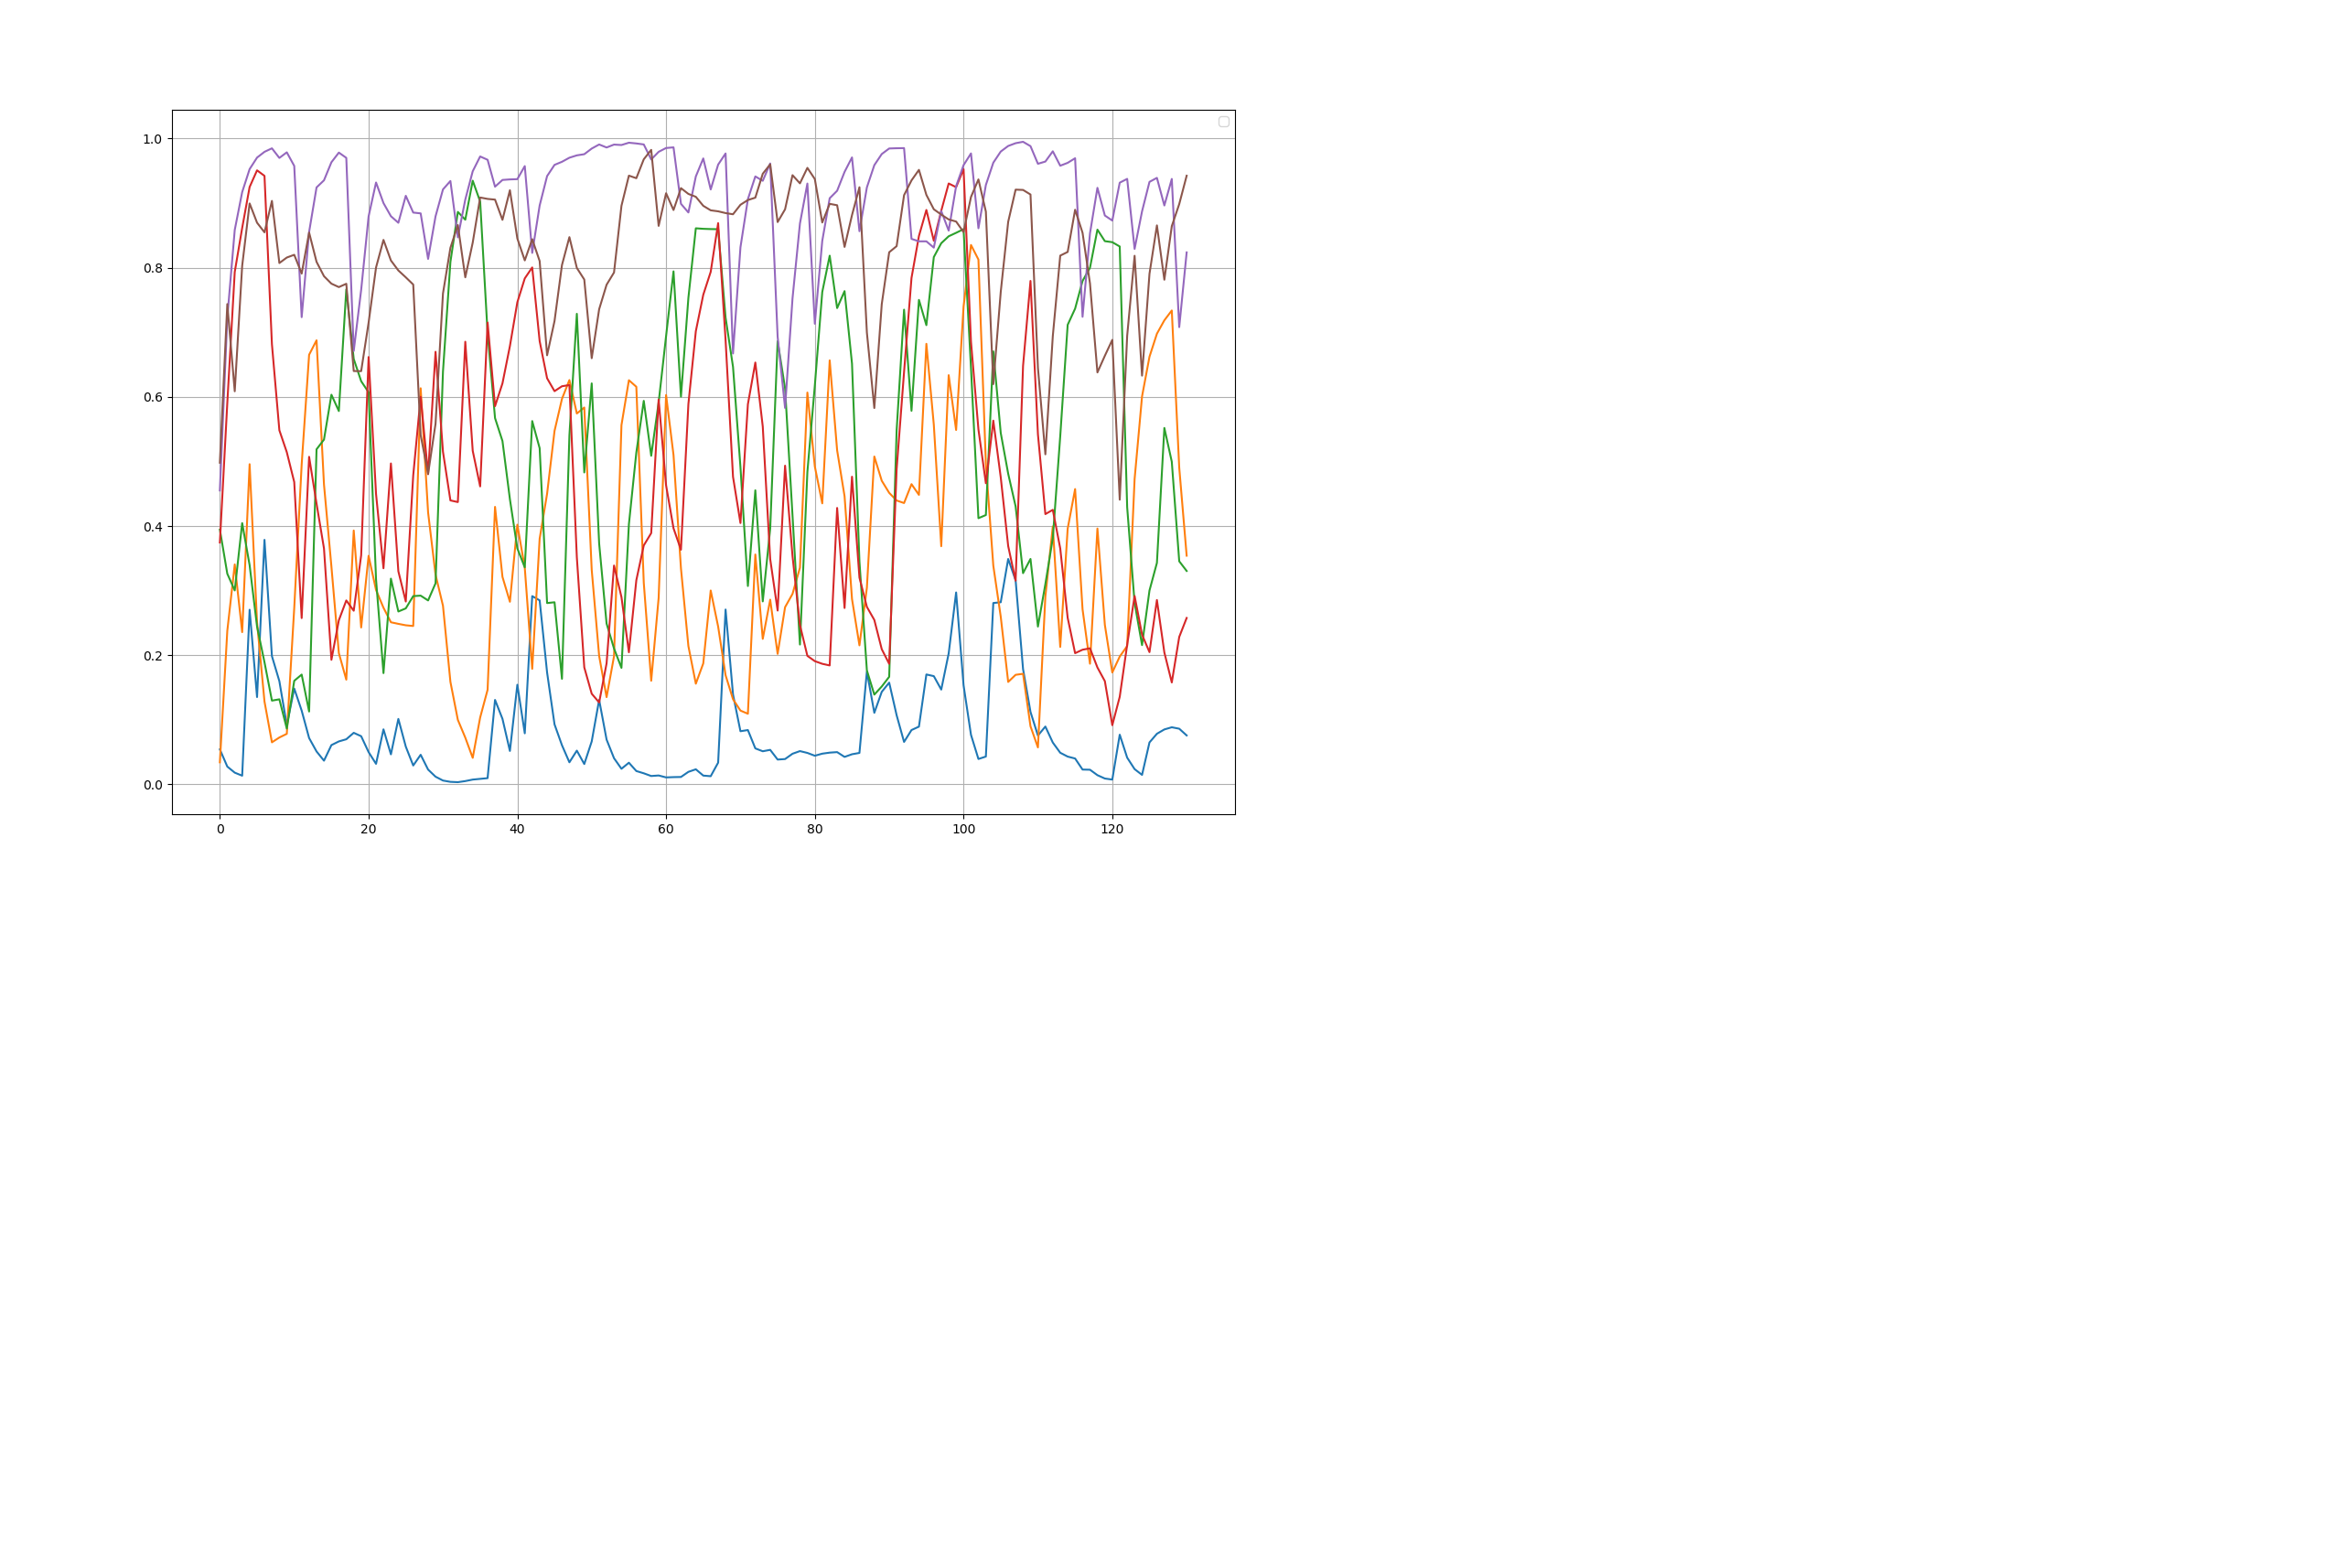

In [ ]:
n_generations = 10000
p1_history = np.zeros((1000, N_ACTIONS*N_CARDS))
p2_history = np.zeros((1000, N_ACTIONS*N_CARDS))


fig, ax = plt.subplots(figsize = (15,10))
plt.ion()

fig.show()
fig.canvas.draw()
p1_turn = False
time_step = 0

best_indivudal_1 = 0;
best_indivudal_2 = 0;
for generation in range(n_generations):
    
    if(generation % 50) : p1_turn = not p1_turn
    
    for i in range(0,POPULATION_SIZE,2):
        if(p1_turn):
            ind11 = tournament_selection(p1,f1)
            ind12 = tournament_selection(p1,f1)
            
            child_11, child_12 = crossover(p1[ind11], p1[ind12])
            
            child_11 = mutate(child_11)
            child_12 = mutate(child_12)
            
            new_p1[i] = child_11
            new_p1[i+1] = child_12
            
            best_indivudal_1 = np.argmax(f1)
            
            new_p1[0] = p1[best_indivudal_1]
            
            p1 = new_p1.copy()
        
        else:
            
            ind21 = tournament_selection(p2,f2)
            ind22 = tournament_selection(p2,f2)
        
        
            child_21, child_22 = crossover(p2[ind21], p2[ind22])
        
        
            child_21 = mutate(child_21)
            child_22 = mutate(child_22)
        
        
            new_p2[i] = child_21
            new_p2[i+1] = child_22
        
    
            best_indivudal_2 = np.argmax(f2)

            new_p2[0] = p2[best_indivudal_2]

            p2 = new_p2.copy()
    
    f1,f2 = evaluate(p1,p2)
    
    
    if(generation % 10 == 0):
        
        for card in range(N_CARDS):
            v1 = p1[best_indivudal_1][card,0,:]@DECODING_VECTOR
            p1_history[time_step,card*N_ACTIONS] = 0.5*p1_history[time_step-1, card*N_ACTIONS] + 0.5*v1
            
            v2 = p1[best_indivudal_1][card,1,:]@DECODING_VECTOR
            p1_history[time_step,card*N_ACTIONS+1] = 0.5*p1_history[time_step-1, card*N_ACTIONS+1] + 0.5*v2
            
            
            v3 = p2[best_indivudal_2][card,0,:]@DECODING_VECTOR
            p2_history[time_step,card*N_ACTIONS] = 0.5*p2_history[time_step-1, card*N_ACTIONS] + 0.5*v3
            
            v4 = p2[best_indivudal_2][card,1,:]@DECODING_VECTOR
            p2_history[time_step,card*N_ACTIONS+1] = 0.5*p2_history[time_step-1, card*N_ACTIONS+1] + 0.5*v4
        
        time_step += 1
        
    if(generation % 100 == 0):   
        ax.clear()
        ax.grid()
        ax.legend(['c0_a0','c0_a1','c1_a0','c1_a1','c2_a0','c2_a1'])

        ax.plot(p2_history[:time_step,:])
        fig.canvas.draw()            


In [27]:
p1[best_indivudal_1].shape

(3, 2, 10)

In [ ]:
plt.plot(p2_history)

## Best player 1 strategy

In [ ]:
print_player(p1[np.argsort(f1)[-1]])

## Best player 2 strategy

In [29]:
print_player(p2[np.argsort(f2)[-1]])

Card 	      a0 prob 	      a2 prob
  0	|	13%	|	99%
  1	|	44%	|	99%
  2	|	49%	|	85%


<img src="kuhns_poker_no_fold.png">

In [ ]:
# now plot a dynamic graph
import random
N = 40
M = 100
a = [[random.random() for i in range(N)] for j in range(M)]

#first the imports 

import scipy.stats as stats
import numpy as np
import time

In [ ]:
#initialise the graph and settings
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

#iterate - plot, erase
for i in range(0,M):
    #print i
    ax.clear() # - Clear
    h = sorted(a[i])
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    ax.plot(h,fit,'-o') # fit the line
    ax.hist(h,normed=True) # fit the histogram
    fig.canvas.draw()   # draw
    time.sleep(0.5)    #sleep